# This notebook calculates the urbanized proportion of each culvert's watershed
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [2]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import os
import glob
from tqdm import tqdm
import datetime

In [11]:
#This cell shows the proportion of each class of NLCD in a watershed
# File paths
nlcd_file = r'D:\hydrological analysis\data\initial layers\NLCD_2021_5070.tif'
watershed_shp = r"D:\hydrological analysis\data\waterhsed_delineation_dir\020200010406\C170040watershed_poly_50m.shp"

# Load the watershed polygon
watershed_gdf = gpd.read_file(watershed_shp)

# Define custom colors and class names for each class
custom_colors = {
    0: 'black',                    # Unclassified
    11: 'deepskyblue',             # Open Water
    21: 'lightyellow',             # Developed, Open Space
    22: 'wheat',                   # Developed, Low Intensity
    23: 'sandybrown',              # Developed, Medium Intensity
    24: 'firebrick',               # Developed High Intensity
    31: 'khaki',                   # Barren Land
    41: 'forestgreen',             # Deciduous Forest
    42: 'darkgreen',               # Evergreen Forest
    43: 'yellowgreen',             # Mixed Forest
    52: 'olivedrab',               # Shrub/Scrub
    71: 'palegreen',               # Herbaceous
    81: 'lightgreen',              # Hay/Pasture
    82: 'limegreen',               # Cultivated Crops
    90: 'royalblue',               # Woody Wetlands
    95: 'aquamarine'               # Emergent Herbaceous Wetlands
}

# Class descriptions for each code
class_descriptions = {
    0: 'Unclassified',
    11: 'Open Water',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Herbaceous',
    81: 'Hay/Pasture',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Create a colormap based on custom colors
cmap = mcolors.ListedColormap([custom_colors[key] for key in sorted(custom_colors.keys())])

# Function to clip a raster by a polygon and calculate class proportions
def calculate_class_proportions(nlcd_file, watershed_gdf):
    with rasterio.open(nlcd_file) as src:
        # Clip raster to watershed polygon
        out_image, out_transform = mask(src, [mapping(watershed_gdf.geometry.iloc[0])], crop=True)
        out_image = np.ma.masked_where(out_image == -128, out_image)  # Mask NoData
        
        # Calculate proportions
        unique, counts = np.unique(out_image.compressed(), return_counts=True)
        total_pixels = counts.sum()
        proportions = {class_descriptions.get(int(k), 'Unknown'): v / total_pixels for k, v in zip(unique, counts)}
        
        return out_image, out_transform, proportions

# Clip and calculate proportions
clipped_data, transform, class_proportions = calculate_class_proportions(nlcd_file, watershed_gdf)
print("Class proportions within the watershed polygon:", class_proportions)

Class proportions within the watershed polygon: {'Developed, Open Space': np.float64(0.02027679433537174), 'Developed, Low Intensity': np.float64(0.003540392661731574), 'Developed, Medium Intensity': np.float64(0.000643707756678468), 'Developed High Intensity': np.float64(0.000160926939169617), 'Deciduous Forest': np.float64(0.5978435790151271), 'Evergreen Forest': np.float64(0.22030897972320568), 'Mixed Forest': np.float64(0.1393627293208883), 'Herbaceous': np.float64(0.0019311232700354038), 'Hay/Pasture': np.float64(0.000643707756678468), 'Woody Wetlands': np.float64(0.014644351464435146), 'Emergent Herbaceous Wetlands': np.float64(0.000643707756678468)}


In [21]:
# Gather all paths for different watershed files
# Define the root directory to search in
root_dir = r"D:\hydrological analysis\data\waterhsed_delineation_dir"

# Define the pattern to search for shapefiles
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')

# Use glob to find all matching shapefiles
shapefile_paths = glob.glob(pattern, recursive=True)

# Print the number of shapefiles found
print(f"Found {len(shapefile_paths)} shapefiles.")

Found 23955 shapefiles.
CPU times: total: 547 ms
Wall time: 1.69 s


In [41]:
# Load culverts watershed
file_path=r"C:\hydrological analysis\data\waterhsed_delineation_dir\combined_watersheds_info.shp"
culvert = gpd.read_file(file_path)

# Define paths
root_dir = r"D:\hydrological analysis\data\waterhsed_delineation_dir"
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
shapefile_paths = glob.glob(pattern, recursive=True)

nlcd_file = r'D:\hydrological analysis\data\initial layers\NLCD_2021_5070.tif'

# Class descriptions for each code
class_descriptions = {
    0: 'Unclassified',
    11: 'Open Water',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed High Intensity',
    31: 'Barren Land',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Herbaceous',
    81: 'Hay/Pasture',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Initialize columns in culvert for class proportions and CN values
for class_name in class_descriptions.values():
    culvert[f'{class_name}_proportion'] = np.nan



# Function to calculate class proportions
def calculate_class_proportions(nlcd_file, watershed_gdf):
    with rasterio.open(nlcd_file) as src:
        out_image, out_transform = mask(src, [mapping(watershed_gdf.geometry.iloc[0])], crop=True)
        out_image = np.ma.masked_where(out_image == -128, out_image)  # Mask NoData
        
        unique, counts = np.unique(out_image.compressed(), return_counts=True)
        total_pixels = counts.sum()
        # Set proportion to 0 for any missing classes
        proportions = {class_name: 0 for class_name in class_descriptions.values()}
        # Only update proportions for classes that are present
        for k, v in zip(unique, counts):
            class_name = class_descriptions.get(int(k), 'Unknown')
            if class_name in proportions:
                proportions[class_name] = v / total_pixels
        
        return proportions

# Process each culvert
for error in [50]:
    for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='Processing culverts'):
        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
# Gather all paths for different watershed files

        for path in shapefile_paths:
            if specific_pattern in os.path.basename(path):
                matching_path = path
                break
        
        watershed = gpd.read_file(matching_path)
        watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]

        # Calculate class proportions for the current watershed
        class_proportions = calculate_class_proportions(nlcd_file, watershed)
        for class_name, proportion in class_proportions.items():
            culvert.loc[idx, f'{class_name}_proportion'] = proportion

# Save the updated culvert dataset to a shapefile
file_path = r"C:\hydrological analysis\data\waterhsed_delineation_dir\combined_watersheds_nlcd_proportions.shp"
culvert.to_file(file_path, driver='ESRI Shapefile')
print("Completed processing and saved the updated shapefile.")


Processing culverts: 100%|█████████████████████████████████████████████████████████| 8468/8468 [13:28<00:00, 10.47it/s]
C:\Users\Omid Emamjomehzadeh\AppData\Local\Temp\ipykernel_24912\2772561405.py:91: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  culvert.to_file(file_path, driver='ESRI Shapefile')


Completed processing and saved the updated shapefile.


In [49]:
culvert. drop (['CN_25','CN_50','CN_75'], axis=1)
culvert['urbanized_pro']=culvert['Developed, Open Space_proportion']+culvert['Developed, Low Intensity_proportion'] \
                            +culvert['Developed, Medium Intensity_proportion']+culvert['Developed High Intensity_proportion']
# save to an Excel file
excel_file_path = r"C:\hydrological analysis\data\waterhsed_delineation_dir\combined_watersheds_nlcd_proportions.xlsx"

# Save the culvert dataset to an Excel file
culvert.to_excel(excel_file_path, index=False)
print("Completed processing and saved the updated dataset to Excel.")

Completed processing and saved the updated dataset to Excel.


<Axes: >

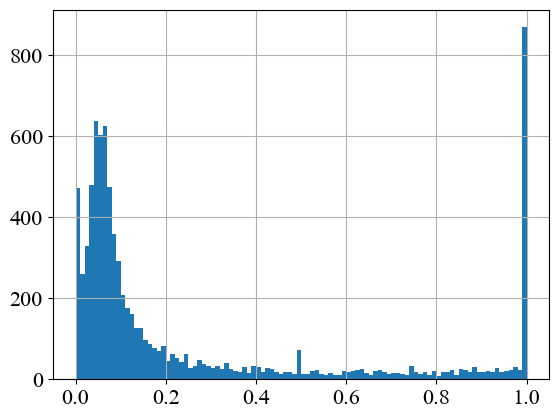

In [51]:
culvert['urbanized_pro']. hist(bins=100)

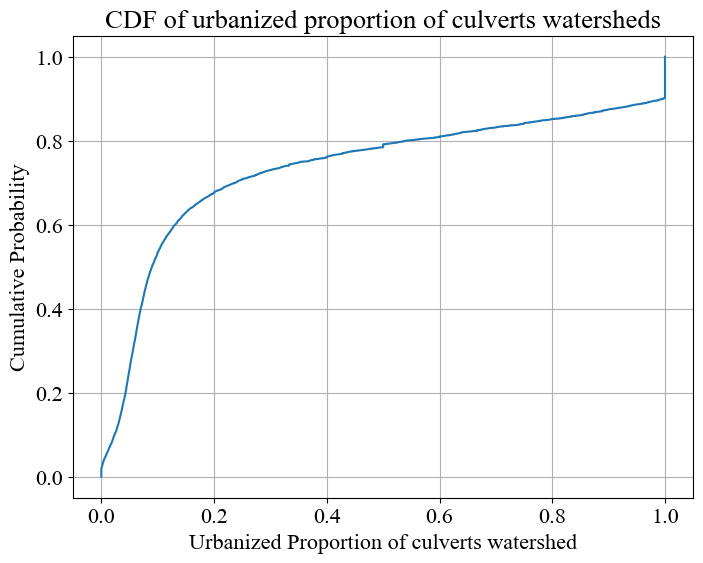

In [63]:
#Plot the ECDF
urbanization_data=np.sort(culvert['urbanized_pro'])
cdf = np.arange(1, len(urbanization_data) + 1) / len(urbanization_data)
# Plot the CDF
plt.figure(figsize=(8, 6))
plt.plot(urbanization_data, cdf, marker=None, linestyle='-')
plt.xlabel('Urbanized Proportion of culverts watershed')
plt.ylabel('Cumulative Probability')
plt.title('CDF of urbanized proportion of culverts watersheds')
plt.grid(True)
plt.show()

In [48]:
culvert.columns

Index(['BIN', 'Ini_lon', 'Ini_lat', 'lonsnap_25', 'latsnap_25', 'Area_25',
       'Peri_25', 'LFP_len_25', 'LFP_S_25', 'Bas_S_25', 'HW_10_25', 'HW_15_25',
       'HW_20_25', 'cul_S105', 'cul_S2025', 'cul_S3025', 'lonsnap_50',
       'latsnap_50', 'Area_50', 'Peri_50', 'LFP_len_50', 'LFP_S_50',
       'Bas_S_50', 'HW_10_50', 'HW_15_50', 'HW_20_50', 'cul_S1050',
       'cul_S2050', 'cul_S3050', 'lonsnap_75', 'latsnap_75', 'Area_75',
       'Peri_75', 'LFP_len_75', 'LFP_S_75', 'Bas_S_75', 'HW_10_75', 'HW_15_75',
       'HW_20_75', 'cul_S1075', 'cul_S2075', 'cul_S3075', 'geometry',
       'Unclassified_proportion', 'Open Water_proportion',
       'Developed, Open Space_proportion',
       'Developed, Low Intensity_proportion',
       'Developed, Medium Intensity_proportion',
       'Developed High Intensity_proportion', 'Barren Land_proportion',
       'Deciduous Forest_proportion', 'Evergreen Forest_proportion',
       'Mixed Forest_proportion', 'Shrub/Scrub_proportion',
       'Herbaceou

In [39]:
# Display the first row of the culvert DataFrame
first_row = culvert.iloc[1]
print(first_row)

BIN                                                                                  C810540
Ini_lon                                                                           -73.413932
Ini_lat                                                                            42.345825
lonsnap_25                                                                        -73.413979
latsnap_25                                                                         42.345944
Area_25                                                                       1009674.981749
Peri_25                                                                          6159.342816
LFP_len_25                                                                       2009.033101
LFP_S_25                                                                               5.828
Bas_S_25                                                                           16.541958
HW_10_25                                                              

In [3]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")


Date and time: 2025-04-30 20:24:33.798227


In [4]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,matplotlib,rasterio,geopandas,os,glob,tqdm

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
matplotlib: 3.8.4
rasterio  : 1.4.3
geopandas : 1.0.1
os        : unknown
glob      : unknown
tqdm      : 4.66.5

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

